In [1]:
%matplotlib inline

4_20151105_noon


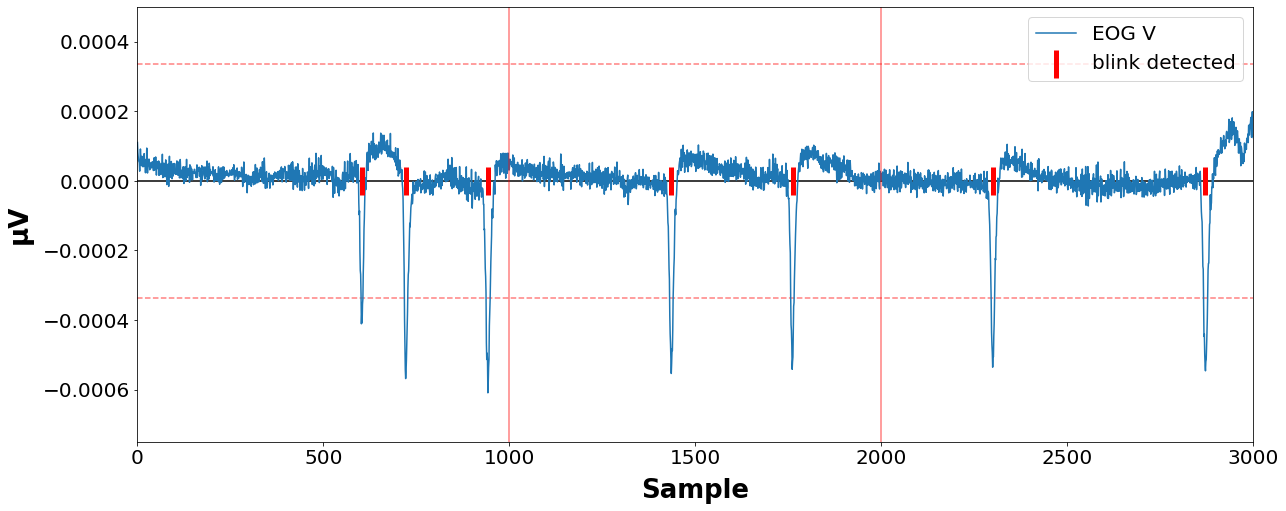

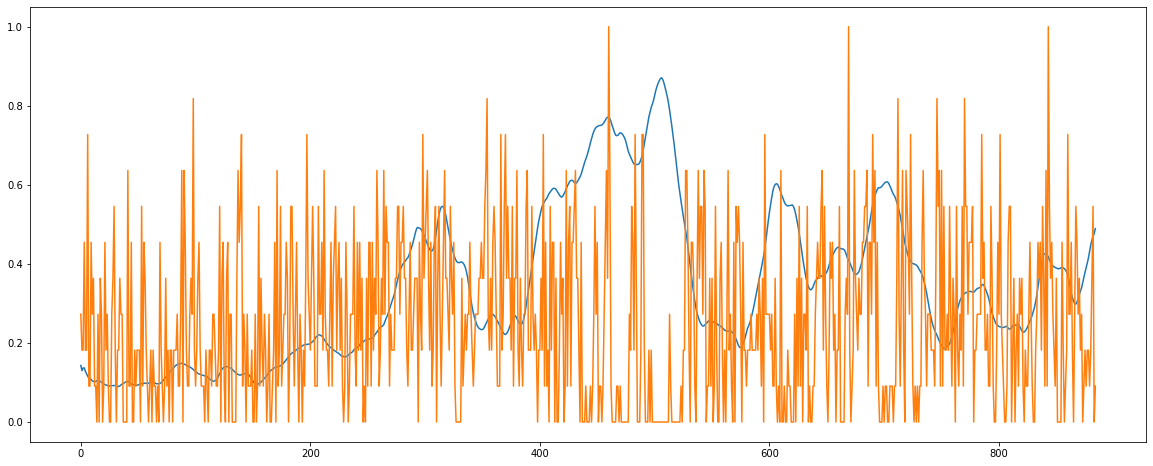

In [3]:
import mne
from mne.externals.pymatreader import read_mat

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

# features_files = ['4_20151105_noon.mat', '4_20151107_noon.mat', '5_20141108_noon.mat','12_20150928_noon.mat','14_20151014_night.mat', '18_20150926_noon.mat', '21_20151016_noon.mat']
features_files = ['4_20151105_noon.mat']

for experiment in features_files:
    print(experiment[:-4])
    mat_data = read_mat(f'./SEED-VIG/Raw_Data/{experiment}')
    
    sfreq = mat_data['EOG']['eog_config']['current_sample_rate']
    samples = mat_data['EOG']['eog_h']*1e-6 
    samples = np.vstack((samples, mat_data['EOG']['eog_v']*1e-6))

    ch_names = ['EOG_H', 'EOG_V']
    ch_types = ["eog"]*len(ch_names)

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    info.set_montage('standard_1020')
    
    raw = mne.io.RawArray(samples, info, verbose=False)
    
    # Busqueda del treshold para el parpadeo
    # https://upcommons.upc.edu/bitstream/handle/2099.1/15598/TFM_Noa%20Quevedo.pdf?sequence=1
    # En los 5 primeros segundos del experimento, buscamos el percentil 2.5 y calculamos su valor absoluto como threshold para detectar parpadeos
    threshold = abs(np.percentile(raw.get_data()[1][:5*1000], 2.5))
    
    blinks = mne.preprocessing.find_eog_events(raw, filter_length='10s', thresh=threshold, verbose=False)
    blinks = blinks.T[0]
    
    # Dibujo de los parpadeos detectados
    start_sample = 0
    n_samples = 3
    
    plt.figure(figsize=(20,8))
    
    plt.axhline(0, c='k', linewidth=1.5, zorder=0)
    plt.axhline(threshold, c='r', linestyle='--', zorder=0, alpha=0.5)
    plt.axhline(-threshold, c='r', linestyle='--', zorder=0, alpha=0.5)
    
    plt.plot(mat_data['EOG']['eog_v']*1e-6, zorder=0, label='EOG V')
#     plt.plot(mat_data['EOG']['eog_h']*1e-6, zorder=0, label='EOG H')
    
    for i in range(start_sample+1, (start_sample+n_samples)):
        plt.axvline(i*1000, c='r', alpha=0.5)
    
    plt.scatter(blinks, np.zeros(len(blinks)), c='r', s=800, linewidths=5, marker='|', zorder=1, label='blink detected')
    
    plt.xlim(start_sample*1000, (start_sample+n_samples)*1000)
    plt.ylim(-0.00075, 0.0005)
    size_label = 26; plt.xlabel('Sample', fontweight ='bold', labelpad = 10,fontsize = size_label); plt.ylabel('μV', fontweight ='bold', labelpad = 10,fontsize = size_label);
    size_ticks = 20; plt.xticks(fontsize=size_ticks); plt.yticks(fontsize=size_ticks);
    size_legend = 20; plt.legend(loc='upper right', fontsize = size_legend)
    plt.savefig("Images-Test/NOMBRE.pdf", bbox_inches='tight')
    plt.show()
    
    # Creacion de estructura que guarda para cada epoch de 8s los parpadeos detectados en ella
    # otra estructura con solo la cantidad de ellos
    n_samples = 885
    dur_sample = 8 # segs
    len_sample = 8*125
    
    blinks_per_sample = []
    for i in range(n_samples):
        blinks_per_sample.append([])
        
    for val in blinks:
        #print(f'val:{val}, len_sample:{len_sample}, indx:{val//len_sample}')
        blinks_per_sample[val//len_sample].append(val)
    
    n_blinks_per_sample = [0]*n_samples
        
    for i in range(885):
        n_blinks_per_sample[i] = len(blinks_per_sample[i])
        
    scaler = MinMaxScaler(feature_range=(0, 1))
    n_blinks_per_sample = np.array(n_blinks_per_sample)
    n_blinks_per_sample = scaler.fit_transform(n_blinks_per_sample.reshape(-1,1))
    
    # Mostramos la relacion entre el parpadeo y el PERCLOS
    perclos_data = read_mat(f'./SEED-VIG/perclos_labels/{experiment}')
    y = np.array(perclos_data['perclos'])
    
    plt.figure(figsize=(20,8))
    plt.plot(y)
    plt.plot(n_blinks_per_sample)
    plt.show()